# Prophet Model
By Samuel Khoo

### Table of Contents
1. Exploratory Data Analysis
2. Data Preprocessing
3. Iteration 1: Using only the time series

### Import Packages

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet

## Exploratory Data Analysis

In [67]:
df = pd.read_csv('AAPL.csv') #Read the data in
df.Date = pd.to_datetime(df.Date, format='%d/%m/%Y') #Set the date column to datetime
df.set_index('Date', inplace=True) #Set the index to the date column
df = df.rename(columns = {'Adj Close':'Adj_Close'})
df.head(20) #Observe a few rows of data

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2015-09-01,110.150002,111.879997,107.360001,107.720001,100.533249,76845900
2015-09-02,110.230003,112.339996,109.129997,112.339996,104.845024,61888800
2015-09-03,112.489998,112.779999,110.040001,110.370003,103.006447,53233900
2015-09-04,108.970001,110.449997,108.510002,109.269997,101.979836,49996300
2015-09-08,111.750000,112.559998,110.320000,112.309998,104.817017,54843600
2015-09-09,113.760002,114.019997,109.769997,110.150002,102.801125,85010800
2015-09-10,110.269997,113.279999,109.900002,112.570000,105.059677,62892800
2015-09-11,111.790001,114.209999,111.760002,114.209999,106.590263,49915500
2015-09-14,116.580002,116.889999,114.860001,115.309998,107.616867,58363400


### Data Visualisation

In this section, I graph the adjusted close price time series against the volume to determine any seasonality or holidays that may be useful when fine tuning the Prophet model.

Text(0, 0.5, 'Volume')

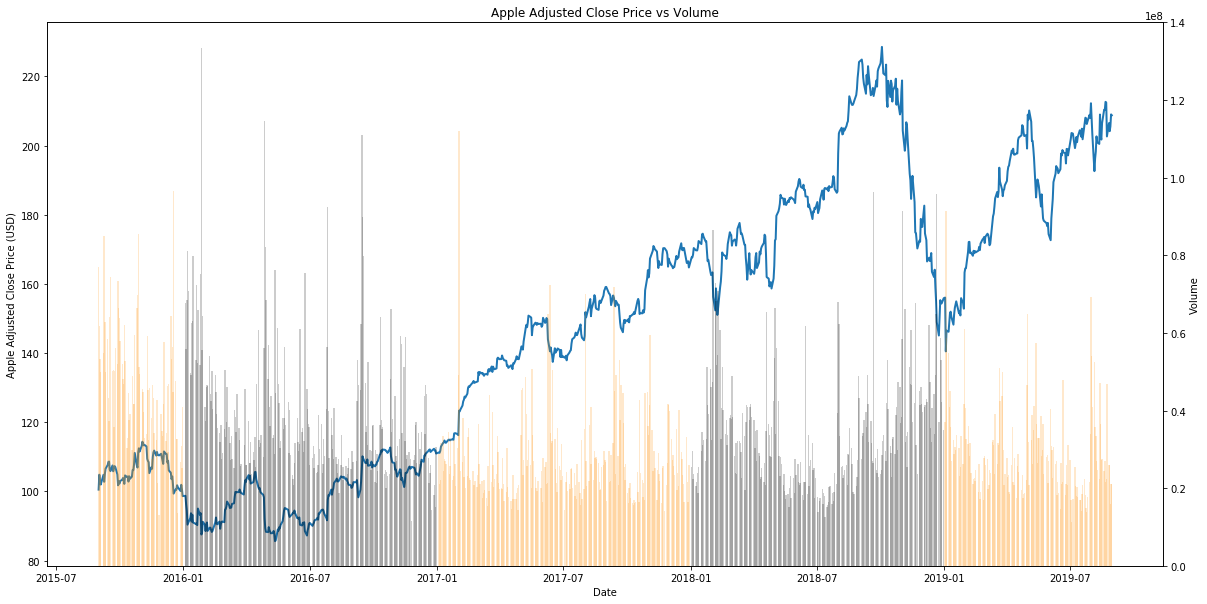

In [68]:
# Split the dataset into the different years
year_2015 = df[df.index < '2016-01-01']
year_2016 = df[(df.index >= '2016-01-01') & (df.index < '2017-01-01')]
year_2017 = df[(df.index >= '2017-01-01') & (df.index < '2018-01-01')]
year_2018 = df[(df.index >= '2018-01-01') & (df.index < '2019-01-01')]
year_2019 = df[df.index >= '2019-01-01']

# Build the plot
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()  # set up the 2nd axis
ax1.plot(df.Adj_Close, linewidth=2) #plot the Adjusted Close Price on axis 1

# Plot the yearly data as bar plots and changes the color for each year
ax2.bar(year_2015.index, year_2015.Volume,width=2, alpha=0.2, color='darkorange')
ax2.bar(year_2016.index, year_2016.Volume,width=2, alpha=0.2, color='black')
ax2.bar(year_2017.index, year_2017.Volume,width=2, alpha=0.2, color='darkorange')
ax2.bar(year_2018.index, year_2018.Volume,width=2, alpha=0.2, color='black')
ax2.bar(year_2019.index, year_2019.Volume,width=2, alpha=0.2, color='darkorange')
 
ax2.grid(b=False) # turn off grid 2

# Label the graph
ax1.set_title('Apple Adjusted Close Price vs Volume')
ax1.set_ylabel('Apple Adjusted Close Price (USD)')
ax1.set_xlabel('Date')
ax2.set_ylabel('Volume')

In [18]:
# seasonality - quarter reports, year end sell off etc.
# holidays/events - apple product releases

In [66]:
year_2019.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
839,2019-01-02,154.889999,158.850006,154.229996,157.919998,156.049484,37039700
840,2019-01-03,143.979996,145.720001,142.000000,142.190002,140.505798,91312200
841,2019-01-04,144.529999,148.550003,143.800003,148.259995,146.503891,58607100
842,2019-01-07,148.699997,148.830002,145.899994,147.929993,146.177811,54777800
843,2019-01-08,149.559998,151.820007,148.520004,150.750000,148.964386,41025300


## Data Preprocessing

### Train-Test Split

- Training Set: 01/09/2015 to 31/08/2018
- Test Set: 01/09/2018 to 30/08/2019 (31/08/2019 is a Saturday)
- There are some missing dates due to weekends and public holidays

In [92]:
# Split into independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df[['Adj_Close']]

# Get Training set
X_train = X[X.index <= '2018-08-31']
y_train = Y[Y.index <= '2018-08-31']

#Get Test set
X_test = X[X.index > '2018-08-31']
y_test = Y[Y.index > '2018-08-31']

In [89]:
y_train = y_train.reset_index()
y_train = y_train.rename(columns={'Date':'ds', 'Adj_Close':'y'})
y_train.head()

,ds,y
0,2015-09-01,100.533249
1,2015-09-02,104.845024
2,2015-09-03,103.006447
3,2015-09-04,101.979836
4,2015-09-08,104.817017


In [93]:
y_test = y_test.reset_index()
future = y_test[['Date']]
future = future.rename(columns={'Date':'ds'})
future.head()

,ds
0,2018-09-04
1,2018-09-05
2,2018-09-06
3,2018-09-07
4,2018-09-10


## Iteration 1: Using only the time series

In this iteration, we will test the model straight out of the box - without giving any parameters.

In [80]:
m = Prophet()
m.fit(y_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [94]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
245,2019-08-26,279.009957,219.274137,343.508224
246,2019-08-27,279.324440,220.961928,342.787075
247,2019-08-28,279.665792,222.913076,343.107032
248,2019-08-29,279.619950,221.201443,343.929700
249,2019-08-30,279.853523,220.559923,344.603946


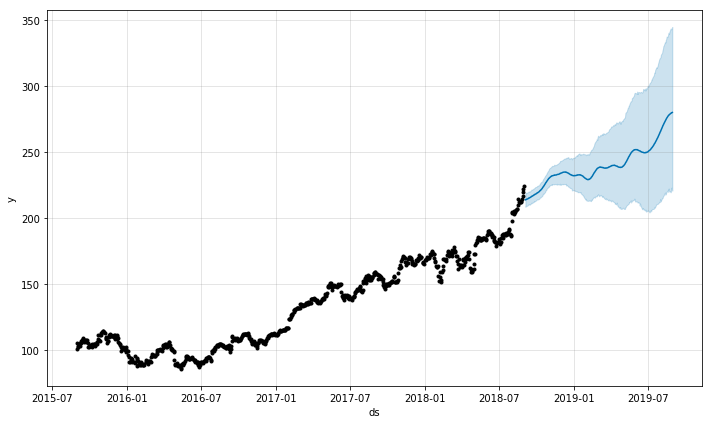

In [95]:
fig1 = m.plot(forecast)

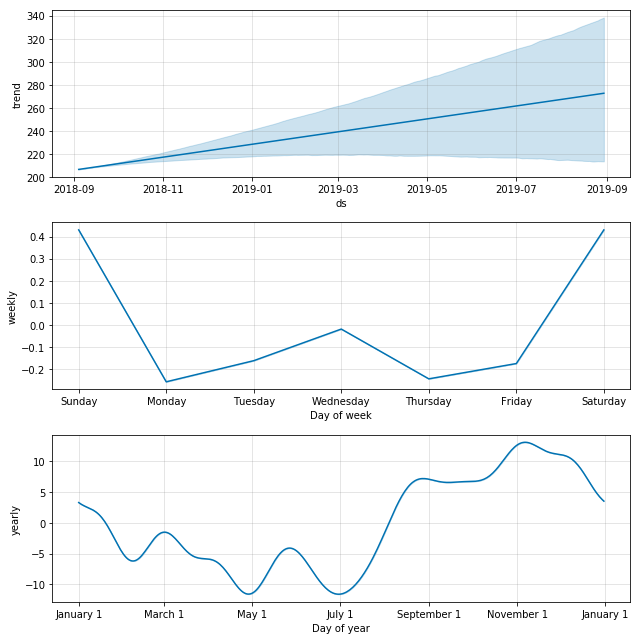

In [96]:
fig2 = m.plot_components(forecast)

### Evaluation:

From this iteration, we see that using past time series data alone is insufficient. The model failed to predict the huge drop in the second half of 2018.